# PyEddyTracker - Model Evaluation
## CONTENTS;
### 1. Load in data
Now, when I'm working from home, this notebook can only be used locally, however when I'm at uni I'll also be able to use this on gadi. 

For now though, we are writing this for a locally run notebook. That means that we need to find the relevant sea-level output from all datasets. 

In [1]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.eddy_feature import Contours

from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations

import xarray as xr
import glob
from netCDF4 import Dataset
from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.feature as feature

In [2]:
# ON GADI ...
# set paths to model output
adt_datapath = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/'
## SRM
eac_003 = adt_datapath + 'eac_eta_1990-2000.nc'
## LRM
sthpac_01 = adt_datapath + 'sthpac_eta_sub.nc'
## PARENT
om2_01 = adt_datapath + 'om2_eta_1990-2020.nc' 

In [4]:
# ON LOCAL MACHINE
# # set paths to model output
# adt_datapath = '/home/johnr/utas/Documents/phd_folder/gadi_notebooks/data/subsetted_data/'

# ## SRM
# eac_003 = adt_datapath + 'eac_eta_1990-2000.nc'
# ## LRM
# sthpac_01 = adt_datapath + 'sthpac_eta_sub.nc'
# ## PARENT
# om2_01 = adt_datapath + 'om2_eta_1990-2020.nc' 

## AVISO
Load SSH Data (starting with AVISO)

In [3]:
ssh = xr.open_dataset(eac_003)
var = 'zos'
ssh

<xarray.Dataset>
Dimensions:  (xh: 594, yh: 760, time: 3803)
Coordinates:
  * xh       (xh) float64 -217.8 -217.7 -217.7 -217.7 ... -198.1 -198.0 -198.0
  * yh       (yh) float64 -46.18 -46.16 -46.13 -46.11 ... -26.01 -25.98 -25.95
  * time     (time) object 1990-02-02 12:00:00 ... 2000-10-31 12:00:00
Data variables:
    zos      (time, yh, xh) float32 ...

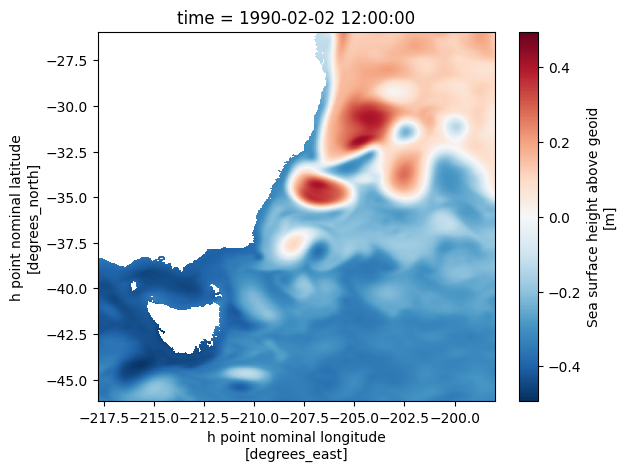

In [4]:
ssh[var].isel(time=0).plot()

# Track Eddies

In [2]:
from py_eddy_tracker.data import get_remote_demo_sample
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances

In [6]:
# Get files of eddy detection
ac_eddy_files = glob.glob(adt_datapath+'id-eddies_eac-003-filtered-dask/AC*.nc'); ac_eddy_files.sort()
cc_eddy_files = glob.glob(adt_datapath+'id-eddies_eac-003-filtered-dask/CC*.nc'); cc_eddy_files.sort()
print(len(ac_eddy_files), len(cc_eddy_files))


3776 3776


In [7]:
%%time
# compute eddy tracks
ac_correspondances = Correspondances(datasets=ac_eddy_files, virtual=3)
cc_correspondances = Correspondances(datasets=cc_eddy_files, virtual=3)
# track eddies
ac_correspondances.track(); cc_correspondances.track()
ac_correspondances.prepare_merging(); cc_correspondances.prepare_merging()
# merge results
ac_eddytracks = ac_correspondances.merge(raw_data=False)
cc_eddytracks = cc_correspondances.merge(raw_data=False)
# capture virtual eddies required
ac_eddytracks.virtual[:] = ac_eddytracks.time==0
cc_eddytracks.virtual[:] = cc_eddytracks.time==0
# interpolate between virtual eddy tracks
ac_eddytracks.filled_by_interpolation(ac_eddytracks.virtual == 1)
cc_eddytracks.filled_by_interpolation(cc_eddytracks.virtual == 1)

High number of conflict : 4 (nb_conflict)
High number of conflict : 15 (nb_conflict)
High number of conflict : 6 (nb_conflict)
High number of conflict : 7 (nb_conflict)
High number of conflict : 6 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 10 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 7 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 14 (nb_conflict)
High number of conflict : 15 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 12 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 12 (nb_conflict)
High number of conflict :

CPU times: user 10min 3s, sys: 2min, total: 12min 3s
Wall time: 25min 30s


In [8]:
print(ac_eddytracks)

/mnt/c/Users/johnr/OneDrive - University of Tasmania/Documents/phd_folder/gadi_notebooks/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


    | 76152 observations from 14642 to 18444 (3803 days, ~20 obs/day)
    |   Speed area      : 0.16 Mkm²/day
    |   Effective area  : 0.29 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.94     17.80     12.21      9.21      7.02     24.67     28.15
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.59     17.29     32.96     21.51     13.40     10.26      3.97      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.16      8.00     16.49     19.34     19.07     21.83     15.12      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

In [9]:
print(cc_eddytracks)

    | 84814 observations from 14642 to 18444 (3803 days, ~22 obs/day)
    |   Speed area      : 0.16 Mkm²/day
    |   Effective area  : 0.25 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       1.09     20.42     14.58     11.42      8.12     24.78     19.58
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       2.20     22.60     29.15     22.07     12.84      7.99      3.16      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.77     11.29     20.09     22.64     19.16     17.39      8.66      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

In [23]:
def get_pixel_range(max_eddy_diameter=450, grid_resolution_in_kms=3):
    max_eddy_radius_in_pixels = max_eddy_diameter / grid_resolution_in_kms
    pixel_upper_limit = np.pi * max_eddy_radius_in_pixels**2
    return pixel_upper_limit

In [25]:
import numpy as np

In [26]:
get_pixel_range()

70685.83470577035

Okay so now I've got these eddy tracks. Let's just work through a few of the examples to get a feel for how to play around with the data.

### Display Fields
Here we use `extract_with_length` to extract eddies with tracks of a particular length. 
* `extract_with_length`: Return the observations within trajectories lasting between [b0:b1]
   * **NOTE: This is length in "days" not in distance!**

In [10]:
# set day threshold to cutoff eddies below that
upper = 100
lower = 50
cc_subset = cc_eddytracks.extract_with_length((lower, upper)) # -1 means no upper limit

In [11]:
cc_subset.nb_tracks

294

Plot Amplitude field

In [14]:
kw_ax = dict(rect=(0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
def start_axes(title):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes(**kw_ax)
    ax.set_xlim(ssh.xh.min().values+360, ssh.xh.max().values+360)
    ax.set_ylim(ssh.yh.min().values, ssh.yh.max().values)
    ax.set_title(title, weight='bold')
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
def update_axes(ax, mappable=None):
    gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    gs.bottom_labels=False
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.04, 0.05, 0.9, 0.01]), orientation='horizontal')
    

In [61]:
def subplot_axes(title, ax):
    ax.set_xlim(ssh.xh.min().values+360, ssh.xh.max().values+360)
    ax.set_ylim(ssh.yh.min().values, ssh.yh.max().values)
    ax.set_title(title, weight='bold', fontsize=10)
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
def update_axes(ax, mappable=None):
    gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    gs.bottom_labels=False
    gs.right_labels=False
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.14, 0.05, 0.75, 0.03]), orientation='horizontal')
    

In [63]:
def plot_subset_given_lengthbounds(dataset, upper, lower, polarity='Cold'):
    ds_sub = dataset.extract_with_length((lower, upper))
    ax = start_axes(f'N: {ds_sub.nb_tracks} | [{lower}, {upper}] days')
    m = ds_sub.scatter(ax, 'age', ref=-10, s=1, transform=ccrs.PlateCarree())
    update_axes(ax, m)

In [ ]:
plot_subset_given_lengthbounds(dataset=cc_eddytracks, lower=0, upper=-1, polarity='Cold')

In [ ]:
plot_subset_given_lengthbounds(dataset=ac_eddytracks, lower=0, upper=-1, polarity='Warm')

In [70]:
def plot_subset_modified(dataset, ax, upper, lower):
    ds_sub = dataset.extract_with_length((lower, upper))
    subplot_axes(title=f'N: {ds_sub.nb_tracks} | [{lower}, {upper}] days', ax=ax)
    m = ds_sub.scatter(ax, 'age', ref=-10, s=1, transform=ccrs.PlateCarree())
    update_axes(ax,m)


Text(0.5, 0.98, 'Warm Core Eddies binned by track duration')

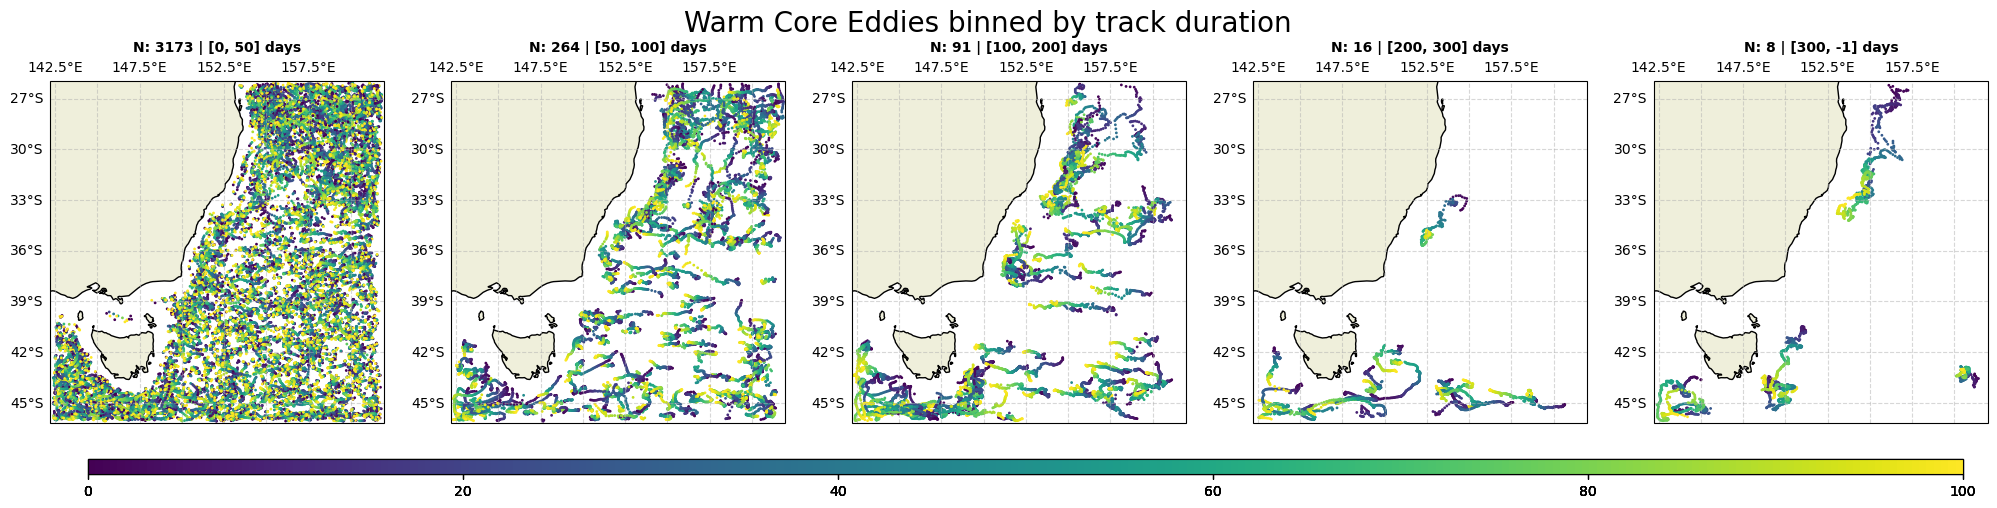

In [69]:
polarity = 'Warm'
fig, axs = plt.subplots(1,5, figsize=(25,5), subplot_kw = {'projection':ccrs.PlateCarree()})
for i, ax in enumerate(axs.flatten()):
    lower_bnd = lower[i]
    upper_bnd = upper[i]
    plot_subset_modified(dataset=ac_eddytracks, ax=ax, lower=lower_bnd, upper=upper_bnd, polarity='Warm')
fig.suptitle(f'{polarity} Core Eddies binned by track duration', fontsize = 20)

Text(0.5, 0.98, 'Cold Core Eddies binned by track duration')

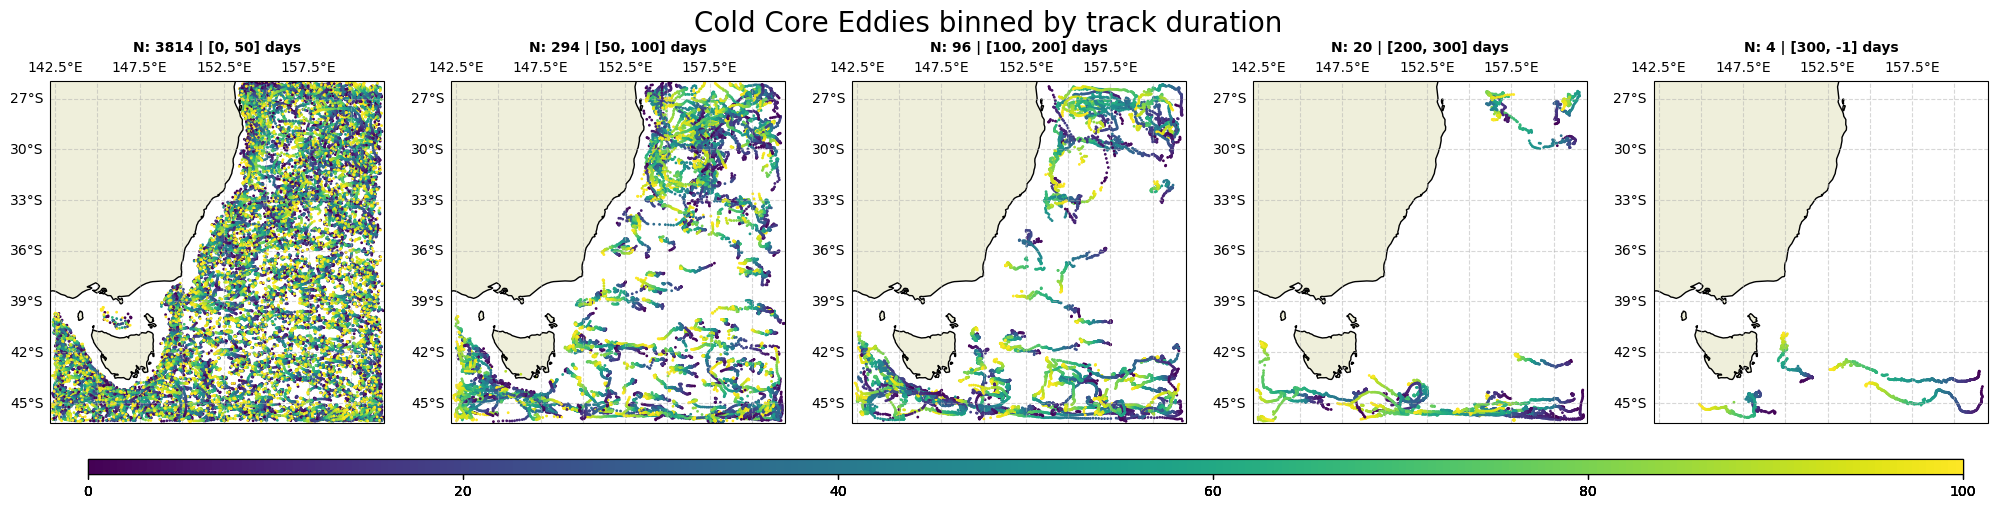

In [71]:
polarity = 'Cold'
fig, axs = plt.subplots(1,5, figsize=(25,5), subplot_kw = {'projection':ccrs.PlateCarree()})
for i, ax in enumerate(axs.flatten()):
    lower_bnd = lower[i]
    upper_bnd = upper[i]
    plot_subset_modified(dataset=cc_eddytracks, ax=ax, lower=lower_bnd, upper=upper_bnd)
fig.suptitle(f'{polarity} Core Eddies binned by track duration', fontsize = 20)

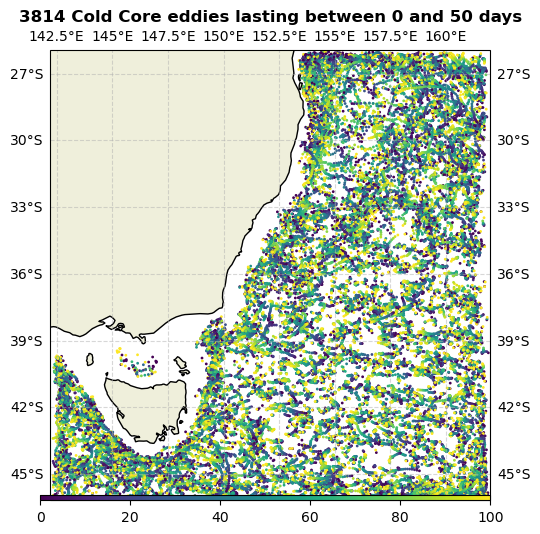

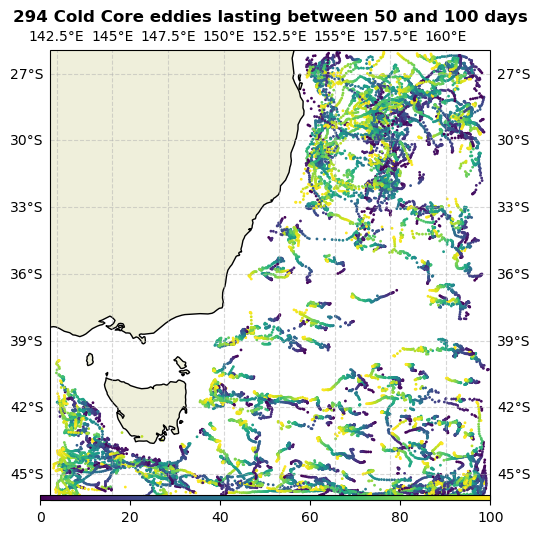

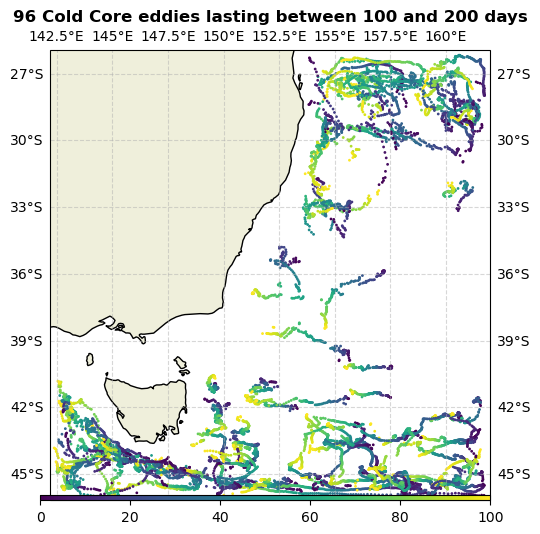

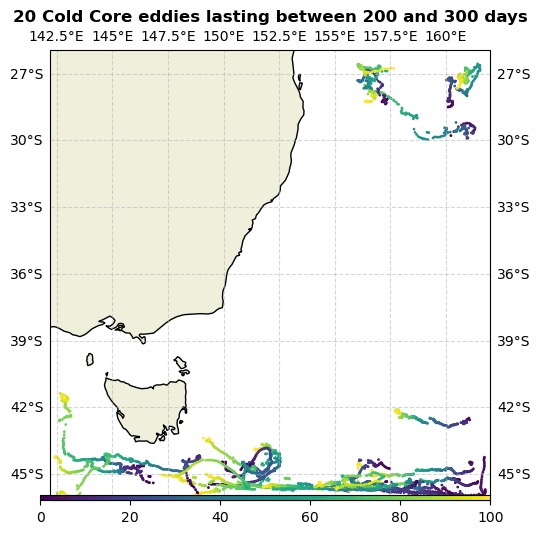

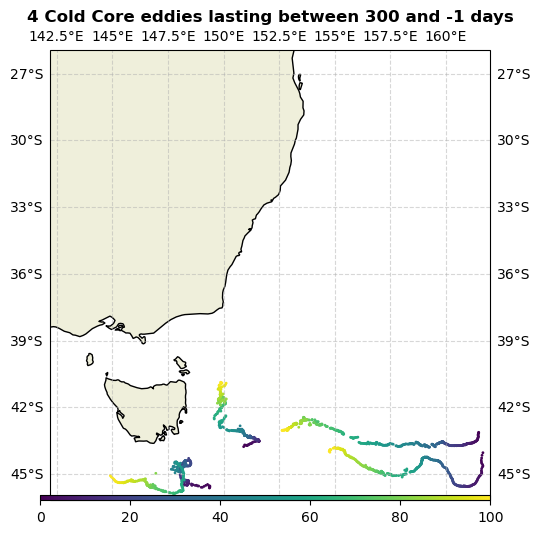

In [21]:
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

for bounds in zip(lower, upper):
    plot_subset_given_lengthbounds(dataset=cc_eddytracks, lower=bounds[0], upper=bounds[1], polarity='Cold')

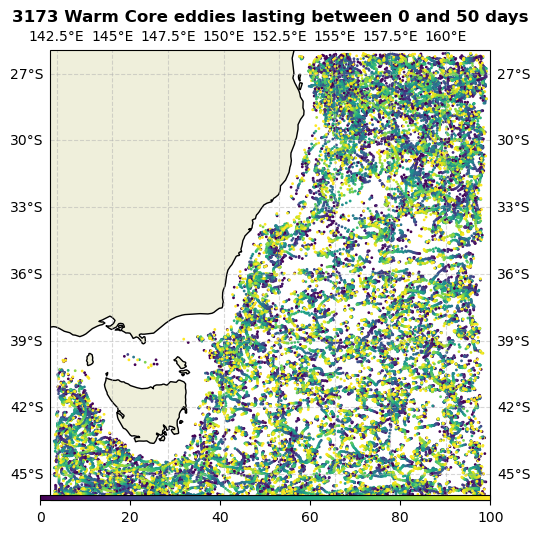

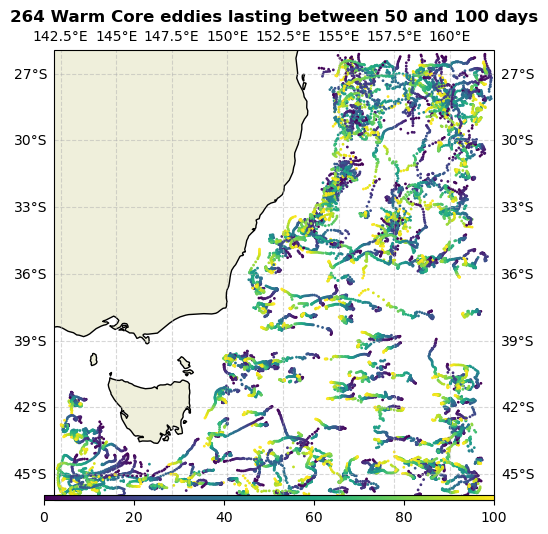

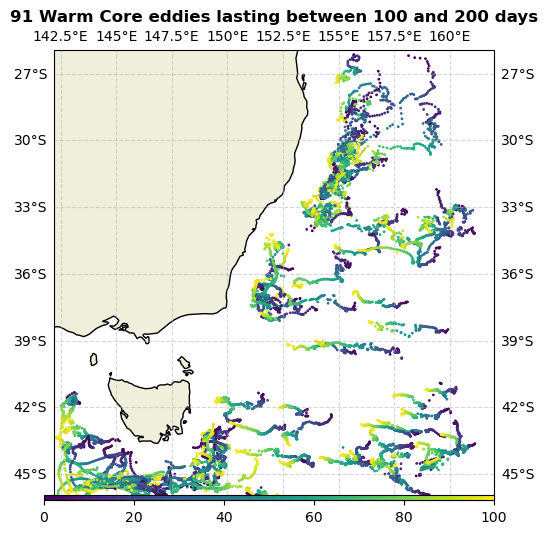

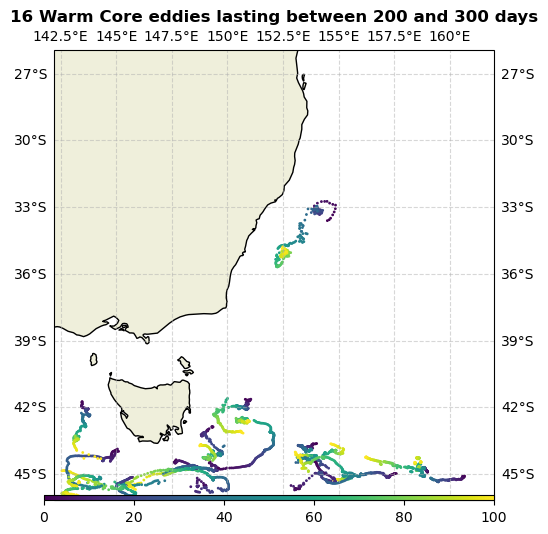

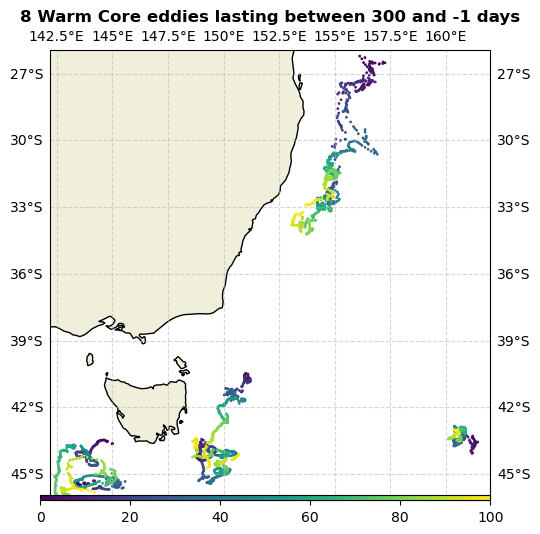

In [22]:
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

for bounds in zip(lower, upper):
    plot_subset_given_lengthbounds(dataset=ac_eddytracks, lower=bounds[0], upper=bounds[1], polarity='Warm')

Text(0.5, 1.0, '4125 Cold-core eddies lasting between 0 and 50 days')

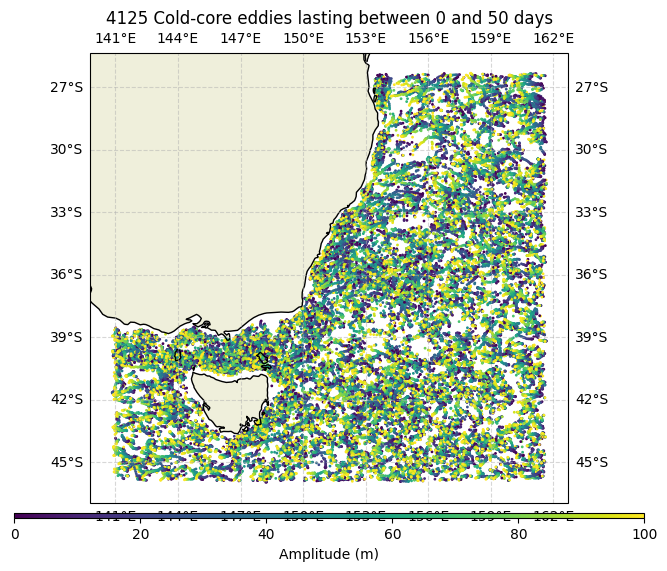

In [60]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes((0.05, 0.1, 0.9, 0.9), projection=ccrs.PlateCarree())
ax.set_aspect("equal")
m = cc_subset.scatter(ax, "age", ref=-10, s=1, transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
cb = plt.colorbar(
        m, cax=fig.add_axes([0.05, 0.07, 0.9, 0.01]), orientation='horizontal'
)
cb.set_label('Amplitude (m)')
ax.set_title(f'{cc_subset.nb_tracks} Cold-core eddies lasting between {lower} and {upper} days')

**Anticyclonic Eddies**

In [55]:
# set day threshold to cutoff eddies below that
upper = 50
lower = 0
ac_subset = ac_eddytracks.extract_with_length((lower, upper)) # -1 means no upper limit
print(ac_subset)

    | 32617 observations from 15706 to 20166 (4461 days, ~7 obs/day)
    |   Speed area      : 0.09 Mkm²/day
    |   Effective area  : 0.13 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.22      6.99      8.91      9.62      7.53     29.00     37.72
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      2.28     23.48     30.13     18.82     15.86      9.44      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      2.05     13.92     18.42     20.64     24.35     20.58      0.05
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00   

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


Plot Amplitude field

Text(0.5, 1.0, '239 Warm-core eddies lasting between 100 and 200 days')

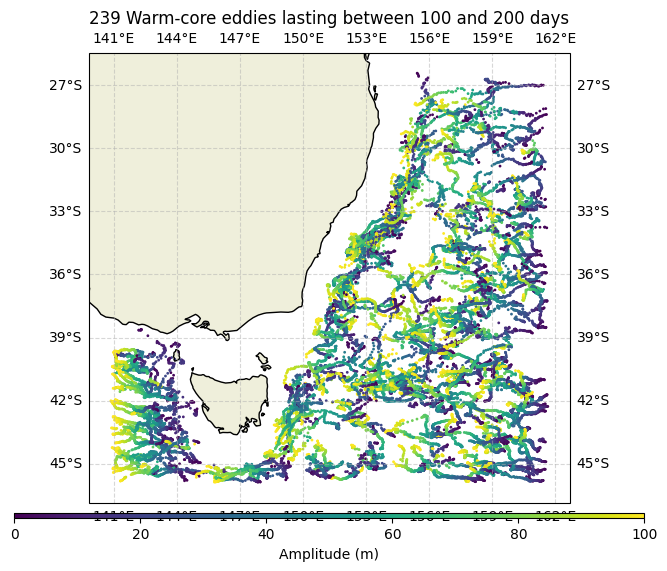

In [56]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes((0.05, 0.1, 0.9, 0.9), projection=ccrs.PlateCarree())
ax.set_aspect("equal")
m = ac_subset.scatter(ax, "age", ref=-10, s=1, transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
cb = plt.colorbar(
        m, cax=fig.add_axes([0.05, 0.07, 0.9, 0.01]), orientation='horizontal'
)
cb.set_label('Amplitude (m)')
ax.set_title(f'{ac_subset.nb_tracks} Warm-core eddies lasting between {lower} and {upper} days')

In [31]:
# set day threshold to cutoff eddies below that
day_threshold = 300
ac_subset = ac_eddytracks.extract_with_length((day_threshold, -1)) # -1 means no upper limit
print(ac_subset)

    | 8254 observations from 15710 to 20166 (4457 days, ~2 obs/day)
    |   Speed area      : 0.03 Mkm²/day
    |   Effective area  : 0.05 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.08      1.72      2.64      3.17      3.42     13.62     75.35
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      1.32     10.02     33.38     21.98     22.80     10.50      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      1.20      4.97      7.28     12.12     37.47     36.95      0.01
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


Plot Amplitude field

Text(0.5, 1.0, 'Warm-core eddies lasting over 300 days')

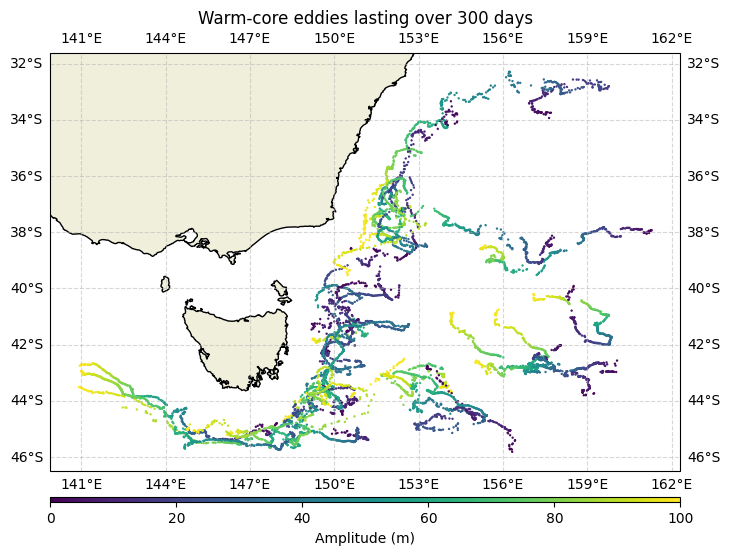

In [38]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes((0.05, 0.1, 0.9, 0.9), projection=ccrs.PlateCarree())
ax.set_aspect("equal")
m = ac_subset.scatter(ax, "age", ref=-10, s=0.5, transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
cb = plt.colorbar(
        m, cax=fig.add_axes([0.05, 0.07, 0.9, 0.01]), orientation='horizontal'
)
cb.set_label('Amplitude (m)')
ax.set_title(f'Warm-core eddies lasting over {day_threshold} days')

In [43]:
# set day threshold to cutoff eddies below that
day_threshold = 300
ac_subset = ac_eddytracks.extract_with_length((200, day_threshold)) # -1 means no upper limit
print(ac_subset)

    | 12906 observations from 15799 to 20166 (4368 days, ~3 obs/day)
    |   Speed area      : 0.04 Mkm²/day
    |   Effective area  : 0.07 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.09      3.50      4.82      5.82      5.97     26.77     53.04
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      1.27     17.28     28.22     23.29     19.82     10.12      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      1.17      7.04     12.32     15.53     28.47     35.45      0.03
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00   

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


Plot Amplitude field

Text(0.5, 1.0, 'Warm-core eddies lasting over 200 days')

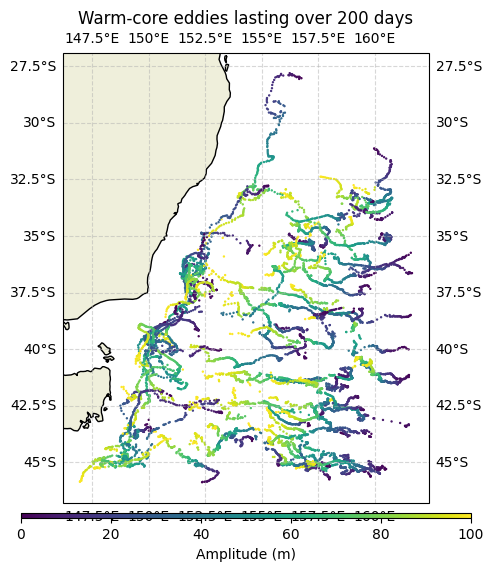

In [45]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0.05, 0.1, 0.9, 0.9), projection=ccrs.PlateCarree())
ax.set_aspect("equal")
m = ac_subset.scatter(ax, "age", ref=-10, s=0.5, transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
cb = plt.colorbar(
        m, cax=fig.add_axes([0.05, 0.07, 0.9, 0.01]), orientation='horizontal'
)
cb.set_label('Amplitude (m)')
ax.set_title(f'Warm-core eddies lasting over 200 days')

In [46]:
# set day threshold to cutoff eddies below that
day_threshold = 300
cc_subset = cc_eddytracks.extract_with_length((200, day_threshold)) # -1 means no upper limit
print(cc_subset)

    | 8616 observations from 15776 to 20166 (4391 days, ~2 obs/day)
    |   Speed area      : 0.02 Mkm²/day
    |   Effective area  : 0.03 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.23      6.66      6.64      7.02      7.23     30.18     42.04
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      2.40     31.64     28.99     14.74     16.96      5.27      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      2.00     13.21     18.27     20.93     29.43     16.17      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


Plot Amplitude field

Text(0.5, 1.0, 'Cold-core eddies lasting over 200 days')

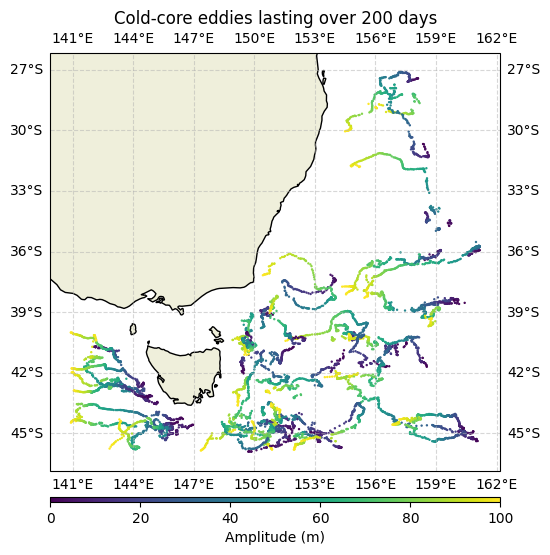

In [48]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0.05, 0.1, 0.9, 0.9), projection=ccrs.PlateCarree())
ax.set_aspect("equal")
m = cc_subset.scatter(ax, "age", ref=-10, s=0.5, transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
cb = plt.colorbar(
        m, cax=fig.add_axes([0.05, 0.07, 0.9, 0.01]), orientation='horizontal'
)
cb.set_label('Amplitude (m)')
ax.set_title(f'Cold-core eddies lasting over 200 days')

The `extract_with_length` is a really good takeaway from the above. 

### Tracks which go through area
Here we use another new method called `position_filter`. This seems to a filter based on the `loess` algorithm, standing for "locally estimated scatterplot smoothing" - chatGPT refers to this as a *"weighted scatterplot smoothing algorithm. It's a non-parameteric method used for smoothing noisy data by fitting a low-degree polynomial to localised subsets of the data"*. 

**Here's the example provided in chatGPT**

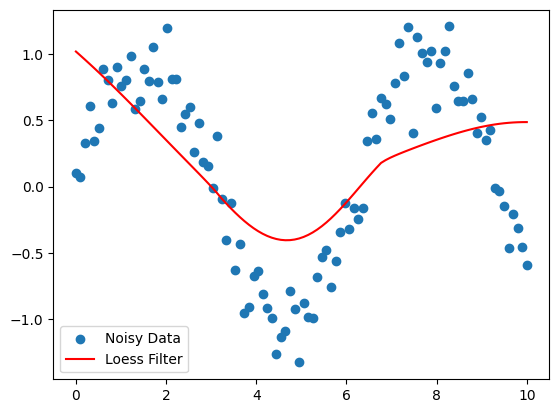

In [45]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Generate some noisy data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.2, size=len(x))

# Apply a loess filter using statsmodels
lowess_result = sm.nonparametric.lowess(y, x)

# Plot the original data and the smoothed curve
plt.scatter(x, y, label='Noisy Data')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', label='Loess Filter')
plt.legend()
plt.show()


Okay that gives a pretty good idea of what we might expect this method to do. Let's go ahead and use this `position_filter`

In [49]:
cc_filt = cc_eddytracks.copy()
ac_filt = ac_eddytracks.copy()
cc_filt.position_filter(median_half_window=1, loess_half_window=5)
ac_filt.position_filter(median_half_window=1, loess_half_window=5)

We extract eddies in the area set below, but we ask to keep `full_path`

In [50]:
x0, x1, y0, y1 = 155, 158, -30, -28
area = dict(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1)
cc_withinbox = cc_filt.extract_with_area(area, full_path=True)
ac_withinbox = ac_filt.extract_with_area(area, full_path=True)

#### Plot

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


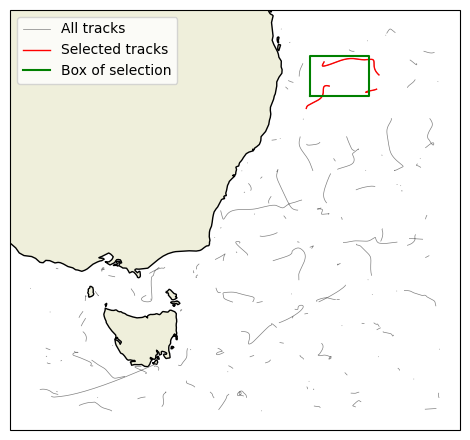

In [52]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
cc_filt.plot(ax, color='grey', lw=0.5, ref=-10, label="All tracks", transform=ccrs.PlateCarree())
cc_withinbox.plot(
    ax, color='r', lw=1, ref=-10, label='Selected tracks', transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
ax.grid()
ax.plot(
    (x0, x0, x1, x1, x0),
    (y0, y1, y1, y0, y0),
    color='g',
    lw=1.5,
    label='Box of selection'
)
ax.legend()

This again is a pretty cool feature and will come in handy and look more interesting when combined with the 'extract_with_length' method as well as longer timeseries.

### One Track
Using the `extract_longer_eddies` method, we determine a threshold whereby 

In [60]:
eddy = ac_eddytracks.extract_with_length((100,-1))
eddy

| 600 observations from 15706 to 15805 (100 days, ~6 obs/day)
    |   Speed area      : 0.09 Mkm²/day
    |   Effective area  : 0.13 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      1.50      4.33     11.17      2.33     21.17     59.50
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.17      7.83     39.17     17.00     18.00     17.83      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.17      2.17      5.33     18.00     43.33     31.00      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     70.77       nan       nan       nan
        Mean effective radius (km):        nan     88.50       nan       nan       nan
        Mean amplitude (cm)       :        nan     11.69       nan       nan       nan
    | 6 tracks (100.00 obs/tracks, shorter 100 obs, longer 100 obs)
    |   4 filled observations (0.67 obs/tracks, 0.67 % of total)
    |   Intepolated speed area      : 0.00 Mkm²/day
    |   Intepolated effective area  : 0.00 Mkm²/day
    |   Distance by day             : Mean 2.47 , Median 2.23 km/day
    |   Distance by track           : Mean 254.64 , Median 235.41 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00
    |   Percent of eddies         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00

In [65]:
# filter
eddy.position_filter(median_half_window=1, loess_half_window=5)

In [81]:
kw_ax = dict(rect=(0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
def start_axes(title):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes(**kw_ax)
    ax.set_title(title, weight='bold')
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
    

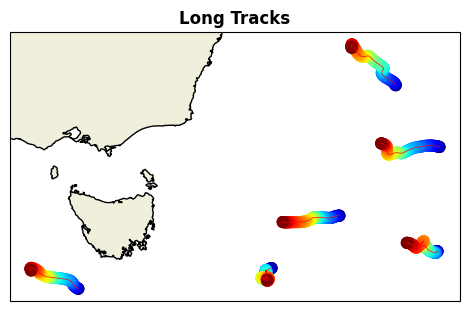

In [82]:
# Plot
ax = start_axes('Long Tracks')
eddy.plot(ax, color='r', lw=0.5)
eddy.scatter(ax, 'n', cmap='jet', s=60)
update_axes(ax)

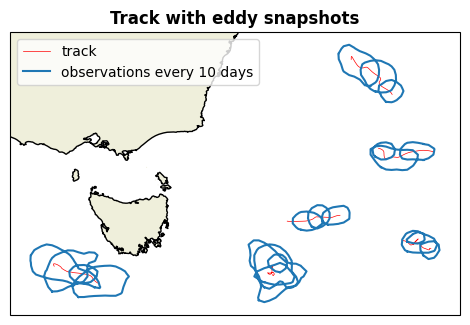

In [85]:
# Plot track with shape snapshots
ax = start_axes('Track with eddy snapshots')
eddy.plot(ax, color='r', lw=0.5, label='track')
eddy.index(range(0, len(eddy), 30)).display(
    ax, intern_only=True, label="observations every 10 days")
ax.legend()

That index method is a good trick - select only particular timesteps of an eddies track

### Display Tracks

In [87]:
# keep eddies longer than 20 weeks
ac_long = ac_eddytracks.extract_with_length((7*10, -1))
cc_long = cc_eddytracks.extract_with_length((7*10, -1))
print(ac_long)
print(cc_long)

    | 942 observations from 15706 to 15805 (100 days, ~9 obs/day)
    |   Speed area      : 0.13 Mkm²/day
    |   Effective area  : 0.20 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      5.52     14.44     13.91      2.87     16.35     46.92
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.53     13.69     35.56     17.09     17.41     15.71      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.42      5.31     14.65     20.17     31.21     28.24      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -1

Position filter for nicer display

In [88]:
ac_long.position_filter(median_half_window=1, loess_half_window=5)
cc_long.position_filter(median_half_window=1, loess_half_window=5)

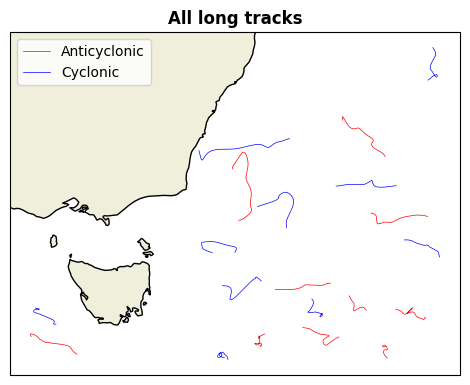

In [89]:
# Plot
ax = start_axes('All long tracks')
ac_long.plot(ax, ref=-10, label="Anticyclonic", color='r', lw=0.5)
cc_long.plot(ax, ref=-10, label="Cyclonic", color='b', lw=0.5)
ax.legend()
ax.grid()

## Tracking Diagnostics
### Geographical Statistics

In [ ]:
# Merge ac and cc
eddies_merged = ac_eddytracks.merge(cc_eddytracks)
step = 0.1

Mean of amplitude in each box

In [104]:
coord_bounds = {'W':adt_aviso.longitude.min().values, 'E':adt_aviso.longitude.max().values,
                'S':adt_aviso.latitude.min().values, 'N':adt_aviso.latitude.max().values}

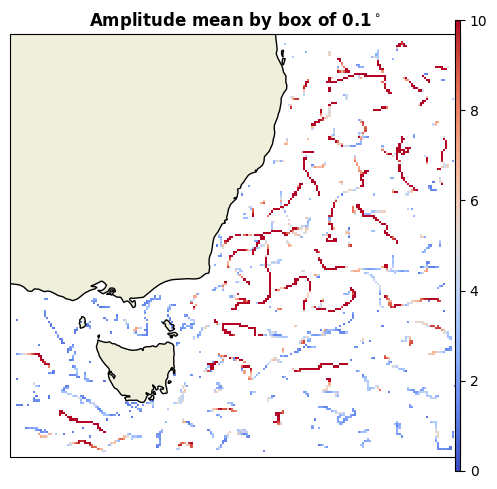

In [107]:
ax = start_axes("Amplitude mean by box of %s$^\circ$" % step)
g = eddies_merged.grid_stat(((coord_bounds['W'], coord_bounds['E'], step), 
                            (coord_bounds['S'], coord_bounds['N'], step)), 
                            varname='amplitude')
m = g.display(ax, name='amplitude', vmin=0, vmax=10, factor=100)
ax.grid()
update_axes(ax, m)

Okay, so once we have a lot of data, these ***Eulerian*** methods of visualising and diagnosing the eddy metrics will be really useful and interesting. We can then compare these maps between datasets.

Mean of speed radius in each box